In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.distributions import (
#     Normal, 
#     Bernoulli, 
#     kl_divergence,
# )
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.datasets import fetch_openml
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from tqdm import tqdm



In [ ]:
# from multiprocessing import cpu_count
# from pathlib import Path
# import json
# from abc import (
#     ABC,
#     abstractmethod,
# )
# from loguru import logger
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# from torch.distributions import (
#     Normal, 
#     Bernoulli,
#     kl_divergence,
# )
# import lightning as L
# from huggingface_hub import (
#     HfApi, 
#     hf_hub_download,
# )


# from deep_genomics.utils import (
#     get_activation_fn,
#     ACTIVATION_MAP,
#     set_seed,
# )
# from deep_genomics.losses import (
#     beta_vae_loss, 
#     beta_tcvae_loss,
# )
# from deep_genomics.metrics import (
#     binary_confusion_matrix,
# )


# class VariationalEncoder(nn.Module):
#     def __init__(
#             self,
#             input_dim: int,
#             hidden_dims: list,
#             latent_dim: int,
#             activation_fn = nn.ReLU,
#         ):
#         super().__init__()
#         self.input_dim = input_dim
#         self.hidden_dims = list(hidden_dims)
#         self.latent_dim = latent_dim
#         if isinstance(activation_fn, str):
#             activation_fn = ACTIVATION_MAP[activation_fn]
#         self.activation_fn = activation_fn
        
#         # Build encoder with progressive compression
#         encoder_layers = []
#         prev_dim = input_dim
        
#         for hidden_dim in hidden_dims:
#             encoder_layers.extend([
#                 nn.Linear(prev_dim, hidden_dim),
#                 activation_fn(),
#             ])
#             prev_dim = hidden_dim
        
#         self.encoder = nn.Sequential(*encoder_layers)

#         # Encoder heads
#         last_hidden_dim = hidden_dims[-1]
#         self.fc_mu = nn.Linear(last_hidden_dim, latent_dim)
#         self.fc_logvar = nn.Linear(last_hidden_dim, latent_dim)

#     def forward(self, x):
#         h = self.encoder(x)
#         mu = self.fc_mu(h)
#         logvar = self.fc_logvar(h)
#         return mu, logvar
        
# class VariationalDecoder(nn.Module):
#     def __init__(
#             self,
#             input_dim: int,
#             hidden_dims: list,
#             latent_dim: int,
#             activation_fn = nn.ReLU,
#         ):
#         super().__init__()
#         self.input_dim = input_dim
#         self.hidden_dims = list(hidden_dims)
#         self.latent_dim = latent_dim
#         if isinstance(activation_fn, str):
#             activation_fn = ACTIVATION_MAP[activation_fn]
#         self.activation_fn = activation_fn


#         # Build decoder - mirror encoder
#         decoder_layers = []
#         prev_dim = latent_dim
        
#         for hidden_dim in reversed(hidden_dims):
#             decoder_layers.extend([
#                 nn.Linear(prev_dim, hidden_dim),
#                 activation_fn()
#             ])
#             prev_dim = hidden_dim
        
#         # Final layer outputs logits (not probabilities)
#         decoder_layers.append(nn.Linear(prev_dim, input_dim))
#         self.decoder = nn.Sequential(*decoder_layers)

#     def forward(self, z):
#         logits = self.decoder(z)
#         return logits
    
# class BaseVAE(L.LightningModule, ABC):
#     def __init__(
#             self,
#             encoder: nn.Module,
#             decoder: nn.Module,
#             learning_rate:float,
#             ) -> None:
#         super().__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.learning_rate = learning_rate
#         # Ignore encoder/decoder save the rest
#         self.save_hyperparameters(ignore=['encoder', 'decoder'])
#     # Default abstract methods
#     @abstractmethod
#     def encode(self, x: torch.Tensor):
#         pass
#     @abstractmethod
#     def decode(self, z: torch.Tensor):
#         pass
#     @abstractmethod
#     def forward(self, x):
#         """Return (p_x, q_z, z) for loss computation"""
#         pass
#     @abstractmethod
#     def sample(self, n_samples:int, device=None):
#         pass
#     @abstractmethod
#     def reconstruct(self, x, batch_size=2048, device=None, return_cpu=True):
#         pass
#     def transform(self, x, batch_size=2048, device=None, return_cpu=True):
#         """
#         Transform input to latent representation (deterministic)
        
#         Args:
#             x: Tensor or array of shape [n_samples, n_features]
#             batch_size: Process in batches of this size for memory efficiency
#             device: Device to move tensors to (e.g., 'cpu', 'mps', 'cuda'). If None, uses model's current device
#             return_cpu: Return output on CPU
        
#         Returns:
#             Latent representations of shape [n_samples, latent_dim]
#         """
#         self.eval()
        
#         if device is None:
#             device = next(self.parameters()).device
        
#         # Convert to tensor if needed
#         if not isinstance(x, torch.Tensor):
#             x = torch.from_numpy(x).float()
        
#         n_samples = x.shape[0]
#         latent_codes = []
        
#         with torch.no_grad():
#             # Process in batches for memory efficiency
#             for i in range(0, n_samples, batch_size):
#                 batch = x[i:i+batch_size].to(device)
#                 mu, _ = self.encode(batch)
#                 latent_codes.append(mu.cpu() if return_cpu else mu)
        
#         return torch.cat(latent_codes, dim=0)

#     # Lightning Methods
#     @abstractmethod
#     def configure_optimizers(self):
#         pass
#     @abstractmethod
#     def training_step(self, batch, batch_idx):
#         pass
#     @abstractmethod
#     def validation_step(self, batch, batch_idx):
#         pass
#     # @abstractmethod
#     # # def test_step(self, batch, batch_idx):
#     #     pass
#     # @abstractmethod
#     # # def predict_step(self, batch, batch_idx):
#     #     pass

#     # HuggingFace
#     def save_pretrained(self, save_directory):
#         """
#         Save model weights and config in HuggingFace format.
        
#         Args:
#             save_directory: Path to directory where model will be saved
#         """
#         save_directory = Path(save_directory)
#         save_directory.mkdir(parents=True, exist_ok=True)
        
#         # Save model weights (PyTorch state_dict)
#         weights_path = save_directory / "pytorch_model.bin"
#         torch.save(self.state_dict(), weights_path)
        
#         # Save hyperparameters as config
#         config_path = save_directory / "config.json"
#         with open(config_path, 'w') as f:
#             json.dump(self.hparams, f, indent=2, default=str)
        
#         print(f"Model saved to {save_directory}")
    
#     @classmethod
#     def from_pretrained(cls, pretrained_model_path, map_location=None):
#         """
#         Load model from HuggingFace format or local directory.
        
#         Args:
#             pretrained_model_path: Local path or HuggingFace Hub model ID
#             map_location: Device to load model weights (e.g., 'cpu', 'cuda', 'mps')
        
#         Returns:
#             Loaded model instance
#         """
#         pretrained_model_path = Path(pretrained_model_path)
        
#         # Load config
#         config_path = pretrained_model_path / 'config.json'
#         if not config_path.exists():
#             raise FileNotFoundError(f"Config file not found: {config_path}")
        
#         with open(config_path, 'r') as f:
#             config = json.load(f)
        
#         # Create model instance (subclass must handle this)
#         # This is why it's a classmethod - subclass implements construction logic
#         model = cls(**config)
        
#         # Load weights
#         weights_path = pretrained_model_path / 'pytorch_model.bin'
#         if not weights_path.exists():
#             raise FileNotFoundError(f"Weights file not found: {weights_path}")
        
#         state_dict = torch.load(weights_path, map_location=map_location)
#         model.load_state_dict(state_dict)
        
#         print(f"Model loaded from {pretrained_model_path}")
#         return model
    
#     def push_to_hub(
#         self,
#         repo_id: str,
#         commit_message: str = "Upload model",
#         private: bool = False,
#         token: str = None,
#     ):
#         """
#         Upload model to HuggingFace Hub.
        
#         Args:
#             repo_id: Repository ID on HuggingFace Hub (e.g., "username/model-name")
#             commit_message: Commit message for the upload
#             private: Whether to make the repository private
#             token: HuggingFace API token (or set HF_TOKEN environment variable)
        
#         Example:
#             model.push_to_hub("myusername/binary-vae-mnist")
#         """
#         from huggingface_hub import HfApi
        
#         # Save to temporary directory
#         import tempfile
#         with tempfile.TemporaryDirectory() as tmp_dir:
#             self.save_pretrained(tmp_dir)
            
#             # Upload to Hub
#             api = HfApi()
#             api.create_repo(
#                 repo_id=repo_id,
#                 private=private,
#                 exist_ok=True,
#                 token=token,
#             )
            
#             api.upload_folder(
#                 folder_path=tmp_dir,
#                 repo_id=repo_id,
#                 commit_message=commit_message,
#                 token=token,
#             )
        
#         print(f"Model uploaded to https://huggingface.co/{repo_id}")

    


In [1]:
# class BinaryBetaVAE(BaseVAE):
#     def __init__(
#             self,
#             # Architecture
#             input_dim: int,
#             hidden_dims: list,
#             latent_dim: int,
#             activation_fn = "ReLU",
#             # Optimizer
#             learning_rate:float = 1e-3,
#             # Loss
#             beta:float = 1.0,
#             # Sub-models
#             encoder: nn.Module = None,
#             decoder: nn.Module = None,
#             ) -> None:
#         # Get activation function
#         if not isinstance(activation_fn, str):
#             activation_fn = activation_fn.__name__
#         # Build encoder/decoder if not provided
#         if all([
#             encoder is None,
#             decoder is None,
#             ]):
#             # Neither provided - build both
#             if any([
#                 input_dim is None, 
#                 hidden_dims is None, 
#                 latent_dim is None,
#                 ]):
#                 raise ValueError(
#                     "Must provide either (encoder, decoder) or "
#                     "(input_dim, hidden_dims, latent_dim)"
#                 )
#             encoder = VariationalEncoder(input_dim, hidden_dims, latent_dim, activation_fn)
#             decoder = VariationalDecoder(input_dim, hidden_dims, latent_dim, activation_fn)
            
#         elif encoder is None or decoder is None:
#             # Only one provided - error
#             raise ValueError("Must provide both encoder and decoder, or neither")
            
#         else:
#             # Both provided - validate they match
#             if encoder.input_dim != decoder.input_dim:
#                 raise ValueError("Encoder and decoder input_dim must match")
#             if list(encoder.hidden_dims) != list(decoder.hidden_dims):
#                 raise ValueError("Encoder and decoder hidden_dims must match")
#             if encoder.latent_dim != decoder.latent_dim:
#                 raise ValueError("Encoder and decoder latent_dim must match")
            
#             # Infer architecture from encoder
#             input_dim = encoder.input_dim
#             hidden_dims = encoder.hidden_dims
#             latent_dim = encoder.latent_dim
#         super().__init__(encoder, decoder, learning_rate)
#         # Store archtecture metadata
#         self.input_dim = input_dim
#         self.hidden_dims = list(hidden_dims)
#         self.latent_dim = latent_dim
#         self.activation_fn = activation_fn
#         self.beta = beta
#         self.save_hyperparameters(ignore=['encoder', 'decoder'])

#     def encode(self, x: torch.Tensor):
#         return self.encoder(x)
#     def decode(self, z: torch.Tensor):
#         return self.decoder(z)
#     def forward(self, x):
#         """Return (p_x, q_z, z) for loss computation"""
#                 # Encode
#         mu, logvar = self.encode(x)

#         # Reparameterization
#         std = torch.exp(0.5 * logvar)
#         # q_z is the approximate posterior - q(z|x)
#         q_z = Normal(mu, std)
#         z = q_z.rsample()

#         # Decode
#         logits = self.decode(z)
#         # p_x is the likelihood - p(x|z)
#         p_x = Bernoulli(logits=logits)

#         return p_x, q_z, z
    
#     def sample(self, n_samples:int, device=None):
#         """
#         Generate samples from the prior p(z) = N(0, I)
#         """
#         self.eval()
#         if device is None:
#             device = next(self.parameters()).device

#         with torch.no_grad():
#             # Sample from distribution
#             z = torch.randn(n_samples, self.latent_dim, device=device)
        
#             # Decode to get reconstructions
#             logits = self.decode(z)
#             samples = torch.sigmoid(logits)
            
#         return samples
#     def reconstruct(self, x, batch_size=2048, device=None, return_cpu=True):
#         """
#         Reconstruct input using posterior mean (deterministic)

#         Args:
#             x: Tensor or array of shape [n_samples, n_features] or [n_features]
#             batch_size: Process in batches of this size for memory efficiency
#             device: Device to move tensors to (e.g., 'cpu', 'mps', 'cuda'). If None, uses model's current device
#             return_cpu: Return output on CPU
        
#         Returns:
#             Reconstruction(s) of shape [n_samples, n_features] or [n_features]
#         """
#         self.eval()
        
#         if device is None:
#             device = next(self.parameters()).device
        
#         # Handle single sample
#         squeeze_output = False
#         if isinstance(x, torch.Tensor) and x.ndim == 1:
#             x = x.unsqueeze(0)
#             squeeze_output = True
#         elif isinstance(x, np.ndarray) and x.ndim == 1:
#             x = x.reshape(1, -1)
#             squeeze_output = True
        
#         # Convert to tensor if needed
#         if not isinstance(x, torch.Tensor):
#             x = torch.from_numpy(x).float()
        
#         n_samples = x.shape[0]
#         reconstructions = []
        
#         with torch.no_grad():
#             # Process in batches for memory efficiency
#             for i in range(0, n_samples, batch_size):
#                 batch = x[i:i+batch_size].to(device)
#                 mu, _ = self.encode(batch)
#                 logits = self.decode(mu)
#                 x_recon = torch.sigmoid(logits)
#                 reconstructions.append(x_recon.cpu() if return_cpu else x_recon)
        
#         result = torch.cat(reconstructions, dim=0)
        
#         # Remove batch dimension if input was single sample
#         if squeeze_output:
#             result = result.squeeze(0)
        
#         return result
    
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(
#             self.parameters(), 
#             lr=self.learning_rate,
#         )
#         return optimizer
    
#     def training_step(self, batch, batch_idx):
#         # Get data
#         x = batch[0]

#         # Forward pass
#         p_x, q_z, z = self.forward(x)

#         # Compute loss
#         losses = beta_vae_loss(
#             x=x,
#             p_x=p_x,
#             q_z=q_z,
#             beta=self.beta,
#         )

#         # Compute reconstruction metrics
#         x_recon = torch.sigmoid(p_x.logits)
#         confusion_matrix = binary_confusion_matrix(x_recon, x, threshold=0.5)

#         # Log loss
#         self.log("train_loss", losses["total_loss"], on_step=False, on_epoch=True, prog_bar=True)
#         self.log("train_recon_loss", losses["recon_loss"], on_step=False, on_epoch=True, prog_bar=True)
#         self.log("train_kl_loss", losses["kl_loss"], on_step=False, on_epoch=True, prog_bar=True)
#         # Log reconstruction metrics
#         self.log('train_precision', confusion_matrix['precision'], on_step=False, on_epoch=True, prog_bar=True)
#         self.log('train_recall', confusion_matrix['recall'], on_step=False, on_epoch=True, prog_bar=True)
#         self.log('train_f1', confusion_matrix['f1'], on_step=False, on_epoch=True)

#         # Return total loss for backpropagation
#         return losses["total_loss"]
    
#     def validation_step(self, batch, batch_idx):
#         # Get data
#         x = batch[0]

#         # Forward pass
#         p_x, q_z, z = self.forward(x)

#         # Compute loss
#         losses = beta_vae_loss(
#             x=x,
#             p_x=p_x,
#             q_z=q_z,
#             beta=self.beta,
#         )

#         # Compute reconstruction metrics
#         x_recon = torch.sigmoid(p_x.logits)
#         confusion_matrix = binary_confusion_matrix(x_recon, x, threshold=0.5)

#         # Log metrics
#         self.log("val_loss", losses["total_loss"], on_step=False, on_epoch=True, prog_bar=True)
#         self.log("val_recon_loss", losses["recon_loss"], on_step=False, on_epoch=True, prog_bar=True)
#         self.log("val_kl_loss", losses["kl_loss"], on_step=False, on_epoch=True, prog_bar=True)
#         # Log reconstruction metrics
#         self.log('train_precision', confusion_matrix['precision'], on_step=False, on_epoch=True, prog_bar=True)
#         self.log('train_recall', confusion_matrix['recall'], on_step=False, on_epoch=True, prog_bar=True)
#         self.log('train_f1', confusion_matrix['f1'], on_step=False, on_epoch=True)
        
#         # Return total loss for backpropagation
#         return losses["total_loss"]



In [1]:
from multiprocessing import cpu_count
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
print("Loading MNIST...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
X = (X > 0).astype(np.float32)
y = y.astype(np.float32)

# Split into train/test (MNIST default split)
X_train_full, X_test = X[:60000], X[60000:]
y_train_full, y_test = y[:60000], y[60000:]

# Split train into train/validation (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.2,  # 20% for validation
    random_state=42,
    stratify=y_train_full  # Maintain class distribution
)

# Create datasets
train_dataset = TensorDataset(
    torch.from_numpy(X_train),
    torch.from_numpy(y_train),
)
val_dataset = TensorDataset(
    torch.from_numpy(X_val),
    torch.from_numpy(y_val),
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test),
    torch.from_numpy(y_test),
)

# Create dataloaders
num_workers = cpu_count() - 1
train_loader = DataLoader(
    train_dataset, 
    batch_size=512, 
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=512, 
    shuffle=False,  # Don't shuffle validation
    num_workers=num_workers,
    persistent_workers=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=512, 
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True
)

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Loading MNIST...
Train samples: 48000
Validation samples: 12000
Test samples: 10000


In [2]:
# Training function
import lightning as L
from deep_genomics.models.vae import BinaryBetaVAE
from deep_genomics.utils import set_seed
from lightning.pytorch.loggers import TensorBoardLogger
# from lightning.pytorch.callbacks import TQDMProgressBar


device = "mps"
set_seed(42)
logger = TensorBoardLogger("lightning_logs", name="vae_testing")

input_dim = train_dataset[0][0].shape[0]
hidden_dims = [512,256,128]
latent_dim = 24
model = BinaryBetaVAE(
    input_dim=input_dim, 
    hidden_dims=hidden_dims, 
    latent_dim=latent_dim,
)
limit_train_batches=None
max_epochs=10
trainer = L.Trainer(
    logger=logger, 
    limit_train_batches=limit_train_batches, 
    max_epochs=max_epochs, 
    accelerator=device,
)
trainer.fit( model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

ModuleNotFoundError: No module named 'deep_genomics.models'

(-0.5, 27.5, 27.5, -0.5)

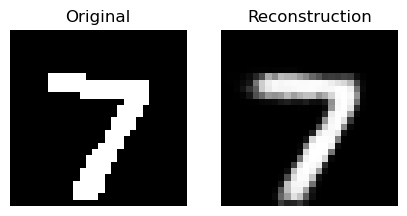

In [19]:
import matplotlib.pyplot as plt
x = X_test[0]
x_recon = model.reconstruct(x) #> 0.5
fig, axes = plt.subplots(1, 2, figsize=(5,5))

axes[0].imshow(x.reshape(28,28), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(x_recon.reshape(28,28), cmap='gray')
axes[1].set_title('Reconstruction')
axes[1].axis('off')


In [20]:
model.save_pretrained("lightning_logs/vae_testing/pretrained_model")

Model saved to lightning_logs/vae_testing/pretrained_model


Model loaded from lightning_logs/vae_testing/pretrained_model


(-0.5, 27.5, 27.5, -0.5)

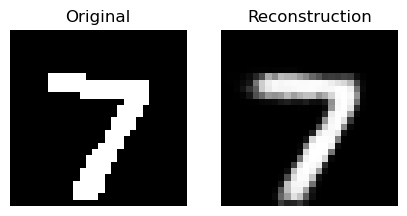

In [ ]:

model2 = BinaryBetaVAE.from_pretrained("lightning_logs/vae_testing/pretrained_model", map_location="mps")
x = X_test[0]
x_recon = model2.reconstruct(x) #> 0.5
fig, axes = plt.subplots(1, 2, figsize=(5,5))

axes[0].imshow(x.reshape(28,28), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(x_recon.reshape(28,28), cmap='gray')
axes[1].set_title('Reconstruction')
axes[1].axis('off')

In [ ]:
hf_token = ""
model.push_to_hub("jolespin/binary-vae-mnist", token=hf_token)

Model saved to /var/folders/kz/sjn7w_851dld8bdf3jf6hbw80000gn/T/tmp2962v7k3


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Model uploaded to https://huggingface.co/jolespin/binary-vae-mnist


In [7]:
# X_latent = model.transform(torch.from_numpy(X_train).to(device)).cpu().numpy()

# import umap
# import matplotlib.pyplot as plt

# # Convert tensor to numpy array

# # Run UMAP to reduce to 2D
# reducer = umap.UMAP(n_components=2)
# X_umap = reducer.fit_transform(X_latent)

# # Ensure labels are integers for coloring
# labels = y_train.astype(int)

# # Plot with digit colors
# plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=5)
# plt.title('UMAP projection (MNIST digits colored)')
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
# plt.colorbar()
# plt.show()